In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('fivethirtyeight')

from scipy import stats
import statsmodels.api as sm

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold, KFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
folder = '/kaggle/input/titanic/'
train = pd.read_csv(folder+'train.csv')
test = pd.read_csv(folder+'test.csv')
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [4]:
train_ids = train['PassengerId'].values
test_ids = test['PassengerId'].values
data = pd.concat([train, test]).set_index('PassengerId')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


# Quick Look at Important Variables

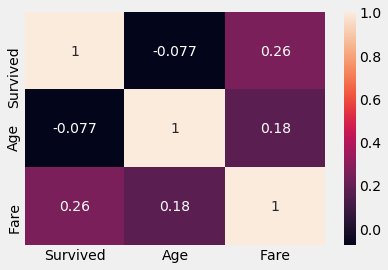

In [6]:
sns.heatmap(data[['Survived', 'Age', 'Fare']].corr(), annot=True);

In [7]:
pd.crosstab(data['Survived'], data['Sex'])

Sex,female,male
Survived,,
0.0,81,468
1.0,233,109


In [8]:
stats.chi2_contingency(pd.crosstab(data['Survived'], data['Sex']))[:2]

(260.71702016732104, 1.1973570627755645e-58)

There's a significant relationship between Sex and Survived.

# Feature Engineering
## Family Size, Number of People Bought Ticket With

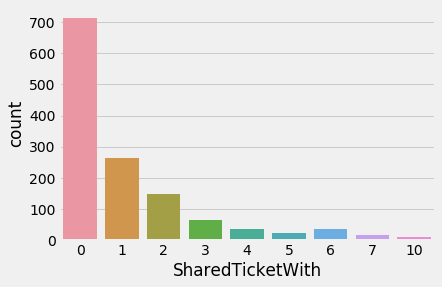

In [9]:
ticket_counts = data['Ticket'].value_counts()
data['SharedTicketWith'] = data['Ticket'].apply(lambda x: ticket_counts[x] - 1)
sns.countplot(data['SharedTicketWith']);

No reason to believe that ticket number has any relationship with survival. Before we drop it, we use it to create a new variable that may have a relationship with survival. 

In [10]:
data['FamSize'] = data['SibSp'] + data['Parch']

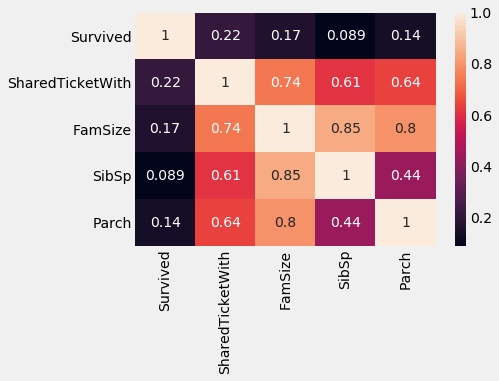

In [11]:
sns.heatmap(data[['Survived', 'SharedTicketWith', 'FamSize', 'SibSp', 'Parch']].corr(method='spearman'), annot=True);

FamSize has a stronger correlation with survival than either of the two variables that compose it. We can run into issues if we keep the 2 variables that summed to FamSize. 

## Cabin Occupants

In [12]:
data['Cabin'].value_counts(dropna=False)

NaN                1014
C23 C25 C27           6
G6                    5
B57 B59 B63 B66       5
B96 B98               4
                   ... 
D43                   1
E12                   1
B102                  1
B11                   1
D48                   1
Name: Cabin, Length: 187, dtype: int64

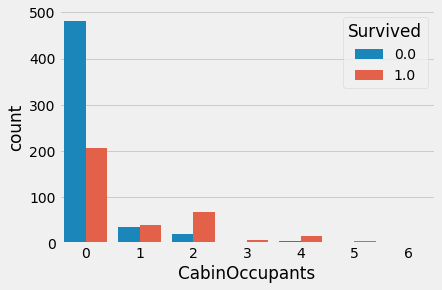

In [13]:
cabin_counts = data['Cabin'].value_counts()
data['CabinOccupants'] = data['Cabin'].apply(lambda cabin: 0 if isinstance(cabin, float) and np.isnan(cabin) else cabin_counts[cabin])
sns.countplot(x = 'CabinOccupants', hue='Survived', data=data);

## Title

In [14]:
names = data['Name']
# sort to ensure longest possible title is chosen
title_list = sorted(['Mr', 'Mrs', 'Ms', 'Miss', 'Master', 'Rev', 'Dr', 'Col', 'Major', 'Capt', 'Jonkheer', 'Countess', 'Mme', 'Don', 'Mlle', 'Dona'], key=len, reverse=True)
names[names.apply(lambda s : not any(t in s for t in title_list))]

Series([], Name: Name, dtype: object)

We added to the above list until all names contained one of the titles. We'll now create a title variable.

In [15]:
titles = names.apply(lambda s : [t for t in title_list if t in s][0])
titles.value_counts()

Mr          749
Miss        260
Mrs         197
Master       61
Col          12
Dr            8
Rev           8
Dona          3
Mlle          2
Major         2
Don           2
Jonkheer      1
Capt          1
Mme           1
Countess      1
Ms            1
Name: Name, dtype: int64

In [16]:
titles = titles.replace(to_replace=['Ms', 'Mlle'], value='Miss')
titles = titles.replace({'Mme': 'Mrs'})
titles = titles.replace(to_replace=['Col', 'Major', 'Capt'], value='Military')
titles = titles.replace(to_replace=['Dona', 'Don', 'Countess', 'Jonkheer', 'Dr', 'Rev'], value='Rare')
titles.value_counts()

Mr          749
Miss        263
Mrs         198
Master       61
Rare         23
Military     15
Name: Name, dtype: int64

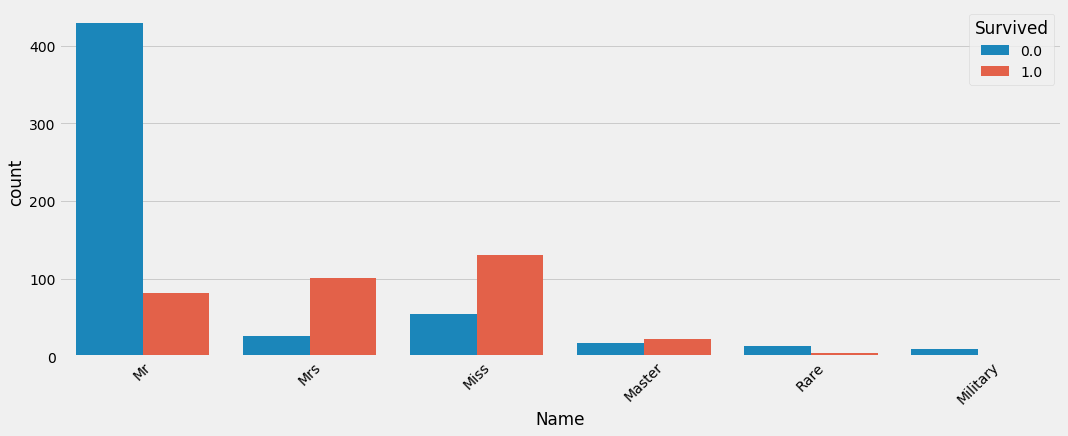

In [17]:
fig, ax = plt.subplots(figsize=(16,6));
graph = sns.countplot(x=titles, hue=data['Survived']);
graph.set_xticklabels(graph.get_xticklabels(), rotation=45);

In [18]:
pd.crosstab(data['Survived'], titles)

Name,Master,Military,Miss,Mr,Mrs,Rare
Survived,,,,,,
0.0,17,9,55,429,26,13
1.0,23,2,130,82,101,4


In [19]:
data['Title'] = titles

A common rule of thumb is to avoid categorical values with a count of less than 10. We follow this rule of thumb by binning all military names and all renaming names with small counts. 

# Data Exploration and Transformation

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


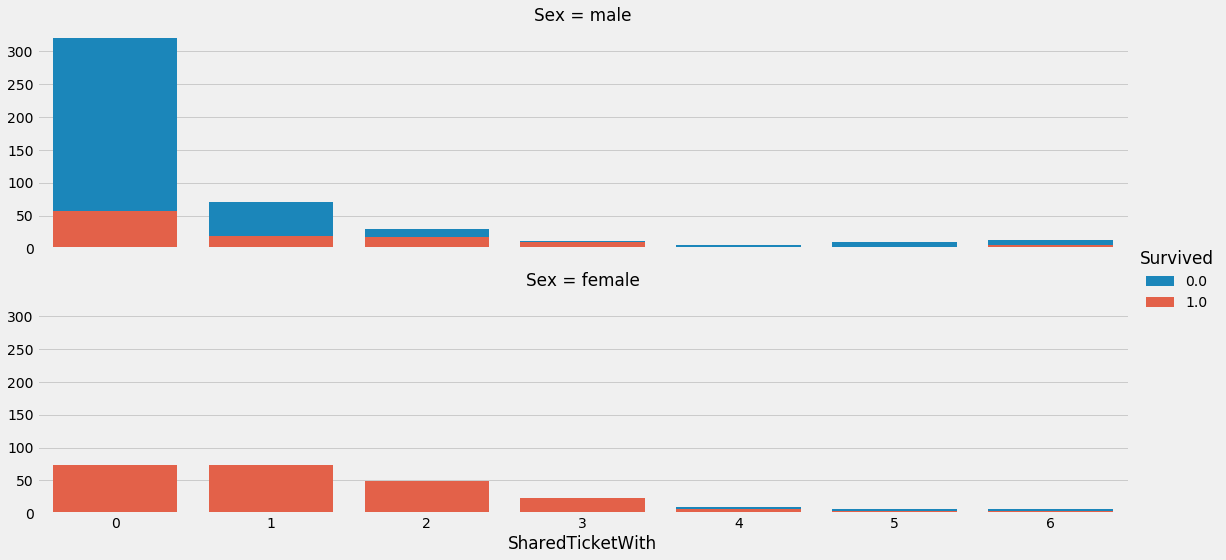

In [20]:
grid = sns.FacetGrid(row='Sex', hue='Survived', data=data, aspect=4, height=4);
grid.map(sns.countplot, 'SharedTicketWith');
grid.add_legend();

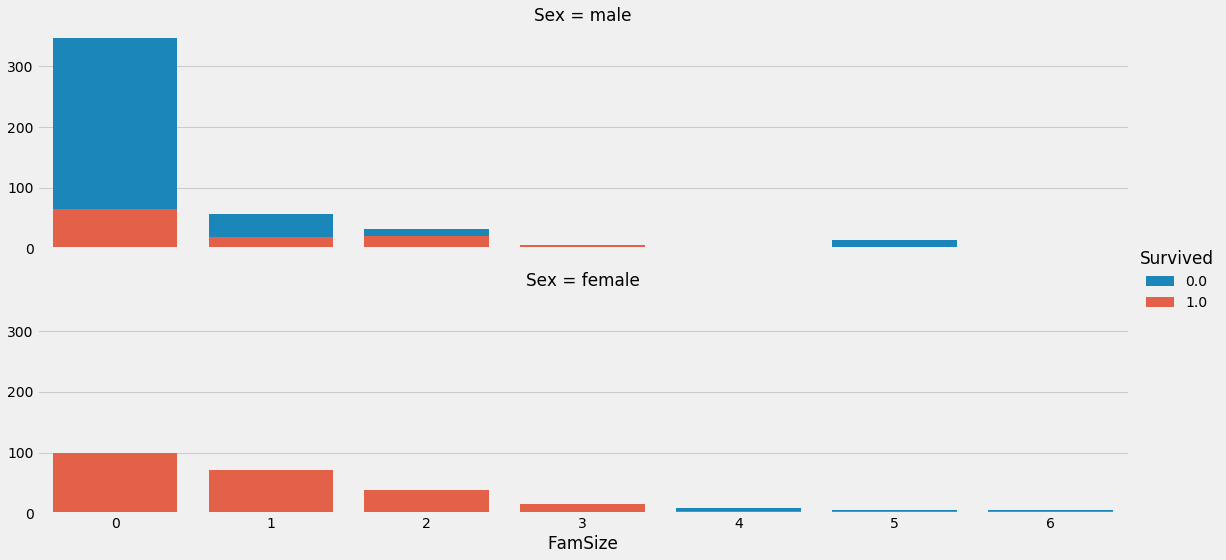

In [21]:
grid = sns.FacetGrid(row='Sex', hue='Survived', data=data, aspect=4, height=4);
grid.map(sns.countplot, 'FamSize');
grid.add_legend();

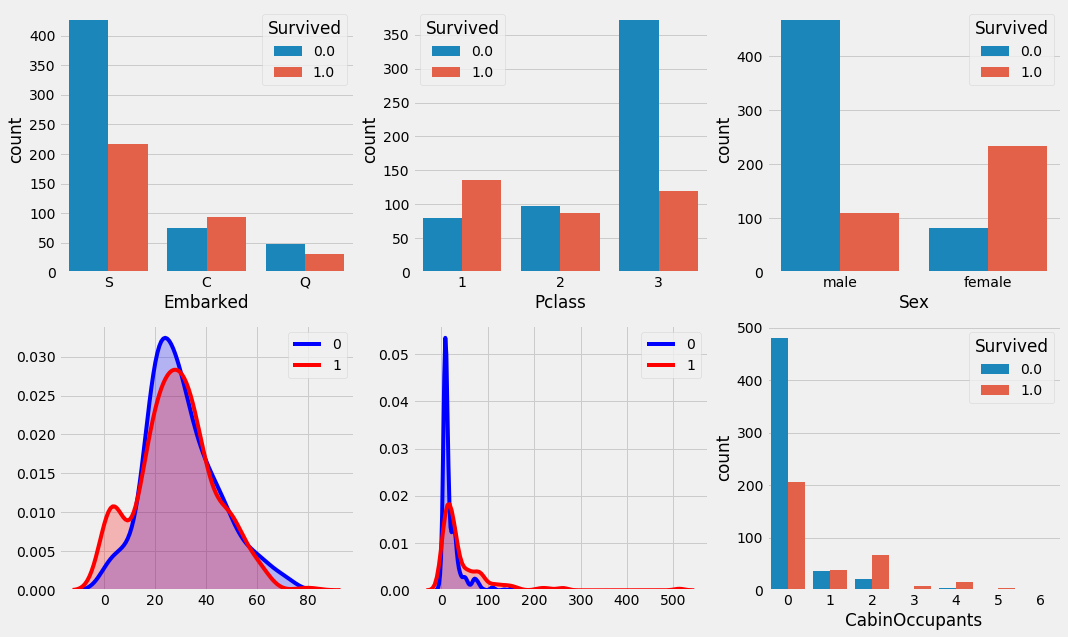

In [22]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16, 10))
sns.countplot(x='Embarked', hue='Survived', data=data, ax=ax[0,0]);
sns.countplot(x='Pclass', hue='Survived', data=data, ax=ax[0,1]);
sns.countplot(x='Sex', hue='Survived', data=data, ax=ax[0,2])
sns.kdeplot(data[data['Survived'] == 0]['Age'], shade=True, color='blue', label=0, ax=ax[1,0]);
sns.kdeplot(data[data['Survived'] == 1]['Age'], shade=True, color='red', label=1, ax=ax[1,0]);
sns.kdeplot(data[data['Survived'] == 0]['Fare'], shade=True, color='blue', label=0, ax=ax[1,1]);
sns.kdeplot(data[data['Survived'] == 1]['Fare'], shade=True, color='red', label=1, ax=ax[1,1]);
sns.countplot(x='CabinOccupants', hue='Survived', data=data, ax=ax[1,2]);

In [23]:
print(data['Fare'].skew())
print(data['Age'].skew())

4.367709134122922
0.40767455974362266


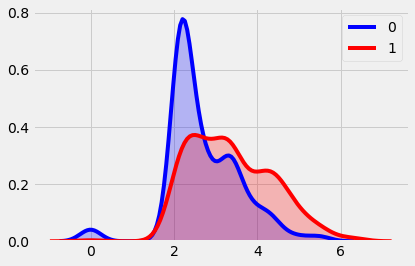

In [24]:
sns.kdeplot(np.log1p(data[data['Survived'] == 0]['Fare']), shade=True, color='blue', label=0);
sns.kdeplot(np.log1p(data[data['Survived'] == 1]['Fare']), shade=True, color='red', label=1);

In [25]:
print(np.log1p(data['Fare']).skew())

0.5418884978395562


We see that Fare's skew can be drastically reduced by the log transform. We'll apply this transform to our data, but first we'll fill in missing data. 

# Imputing Missing Values

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 15 columns):
Age                 1046 non-null float64
Cabin               295 non-null object
Embarked            1307 non-null object
Fare                1308 non-null float64
Name                1309 non-null object
Parch               1309 non-null int64
Pclass              1309 non-null int64
Sex                 1309 non-null object
SibSp               1309 non-null int64
Survived            891 non-null float64
Ticket              1309 non-null object
SharedTicketWith    1309 non-null int64
FamSize             1309 non-null int64
CabinOccupants      1309 non-null int64
Title               1309 non-null object
dtypes: float64(3), int64(6), object(6)
memory usage: 203.6+ KB


## Embarked

In [27]:
data[data['Embarked'].isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,SharedTicketWith,FamSize,CabinOccupants,Title
PassengerId,,,,,,,,,,,,,,,
62,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,1.0,113572,1,0,2,Miss
830,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1.0,113572,1,0,2,Mrs


We'll now fill in missing Embarked values either with the mode Embarked, or by the mode of a meaningful entry group. The latter is more desireable as, if done well, it uses the information at hand to make a more precise estimate of the missing value. 

Both people missing Embarked have have a shared ticket with one another person, but unfortunately they've shared it with each other. Let's see if there's another grouping that we can use.

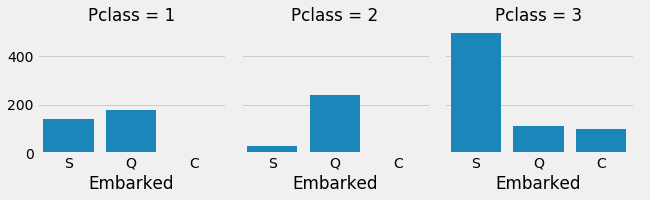

In [28]:
h = sns.FacetGrid(data, col='Pclass');
h.map(sns.countplot, 'Embarked');
h.add_legend();

In [29]:
data.loc[[62, 830], 'Embarked'] = 'Q'

We use the mode of the Embarked for entries in the same Pclass.

## Fare
In imputing the Fare, we'll use a similar approach as above: we'll look for meaningful categories, of which we can take the median Fare value.

In [30]:
data[data['Fare'].isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,SharedTicketWith,FamSize,CabinOccupants,Title
PassengerId,,,,,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,3701,0,0,0,Mr


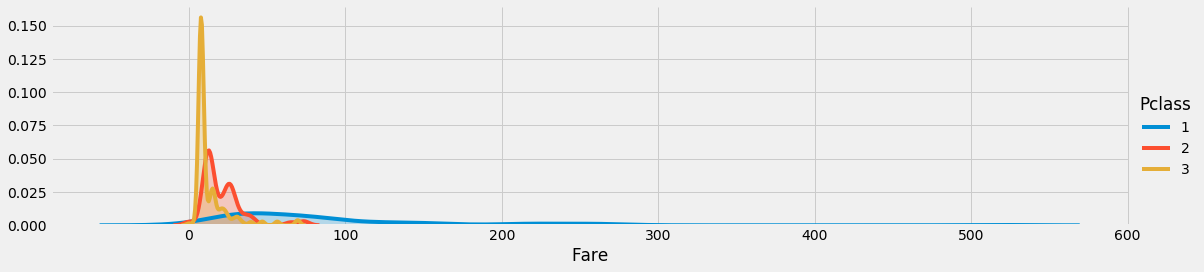

In [31]:
grid = sns.FacetGrid(data=data, hue='Pclass', height=4, aspect=4);
grid.map(sns.kdeplot, 'Fare', shade=True);
grid.add_legend();

In [32]:
data.loc[1044, 'Fare'] = data[data['Pclass'] == 3]['Fare'].median()

## Age
Same approach.

Mr        176
Miss       50
Mrs        27
Master      8
Rare        2
Name: Title, dtype: int64

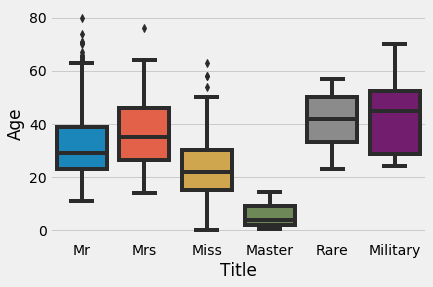

In [33]:
sns.boxplot(x='Title', y='Age', data=data);
data[data['Age'].isna()]['Title'].value_counts()

In [34]:
age_by_title = data.groupby('Title')['Age'].median()
data['Age'] = data.apply(lambda row : age_by_title[row['Title']] if pd.isna(row['Age']) else row['Age'], axis=1)

Title clearly has a relationship with age, so we impute age with the median of each person's title. 

# Feature Selection

In [35]:
data = data.drop(columns=['Ticket', 'SibSp', 'Parch', 'Cabin', 'Name'])

Name, Ticket, and Cabin likely have no relationship with Survival. FamSize is a linear combinations of SibSp and Parch and has a greater biserial correlation with Survived than either of them, so we drop the two of them. 

# Transformation

## Log Transform of Right Skewed Variables

In [36]:
data['Fare_log1p'] = np.log1p(data['Fare'])
data = data.drop(columns=['Fare'])

## Convert Datatypes to Reflect Variable Types
* nonbinary categories: object
* binary categories: bool
* ordinal: int
* numerical: float or int

In [37]:
data['IsMale'] = data['Sex'].apply(lambda x: x == 'male')
data = data.drop(columns=['Sex'])

In [38]:
data['Pclass'] = data['Pclass'].astype(str)
data['Survived'] = data['Survived'].astype(bool)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Age                 1309 non-null float64
Embarked            1309 non-null object
Pclass              1309 non-null object
Survived            1309 non-null bool
SharedTicketWith    1309 non-null int64
FamSize             1309 non-null int64
CabinOccupants      1309 non-null int64
Title               1309 non-null object
Fare_log1p          1309 non-null float64
IsMale              1309 non-null bool
dtypes: bool(2), float64(2), int64(3), object(3)
memory usage: 134.6+ KB


In [40]:
data.to_csv('data_nodummies.csv')

In [41]:
data = pd.read_csv('data_nodummies.csv', index_col='PassengerId')

# Train, Test Split

In [42]:
train = data.loc[train_ids]
test = data.loc[test_ids]

# Dummy Variables

In [43]:
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

# X, y

In [44]:
test = test.drop(columns=['Survived'])
X = train.drop(columns=['Survived'])
y = train['Survived']

# Hyperparameter Optimization

## Method For Multiple Hyperparameters
The complexity of grid search grows multiplicatively with respect to the number of hyperparameters (n). For cases with n >= 2 we will plot the average cross validation accuracy for each value on a model-dependent "rough grid", when all the other paramters are set to their default. This will be used to approximate the "neighborhood" of optimal values. Once the scale of each parameter is determined in this way, we will conduct a grid search of each hyperparameter combination in the neighborhood. If the best parameter combination is found on the boundary of the neighborhood, the boundary is expanded in that direction, else conlude the best parameters have been found. 

For ensemble models with n >= 2 we will use a special approach of the above method. We will find the optimal number of learners for the default learner parameters, then tune the learner-specific parameters in the above fashion, then tune the number of learners for the tuned learner parameters. 

Note that this method is not guaranteed to find an optimal solution, but it is generally accepted as a good approach.  

In [45]:
best_params = {}

In [46]:
def search_1d(model, scaler, param_name, param_list, n_repeats=1, xscale='linear'):
    kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=0)
    grid = GridSearchCV(model, {param_name: param_list}, cv=kfold)
    if scaler is not None:
        pipe = make_pipeline(scaler, grid)
        pipe.fit(X, y)
        grid = pipe[1]
    else:
        grid.fit(X, y)
    accs = np.array(grid.cv_results_['mean_test_score'])
    graph = sns.lineplot(param_list, accs)
    graph.set(xlabel=param_name, ylabel='Accuracy', xscale=xscale)
    return grid.best_params_

### KNN

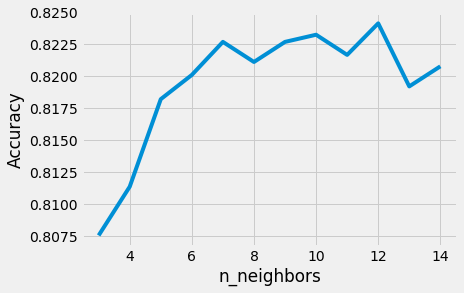

In [47]:
best_params['knn'] = search_1d(KNeighborsClassifier(), MinMaxScaler(), 'n_neighbors', list(range(3, 15)), n_repeats=10)

### SVC

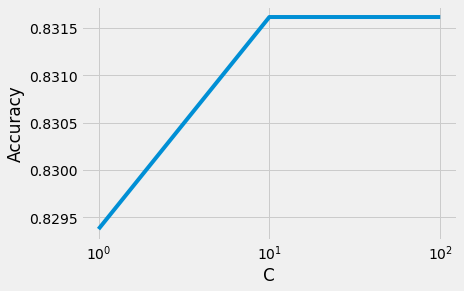

In [48]:
best_params['svc_linear'] = search_1d(SVC(kernel='linear'), RobustScaler(), 'C', [10**i for i in range(0, 3)], n_repeats=1, xscale='log')

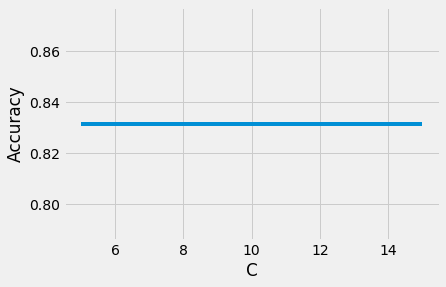

In [49]:
best_params['svc_linear'] = search_1d(SVC(kernel='linear'), RobustScaler(), 'C', [10 + i for i in range(-5, 6)], n_repeats=1)

## SVC with RBF Kernel

{'C': 1}

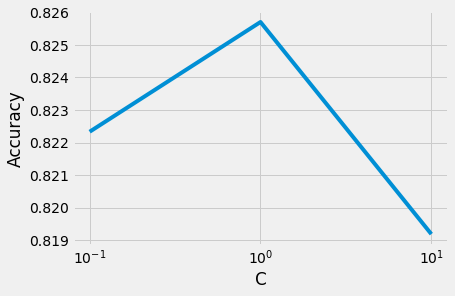

In [50]:
search_1d(SVC(), RobustScaler(), 'C', [10**i for i in range(-1, 2)], n_repeats=10, xscale='log')

{'gamma': 0.1}

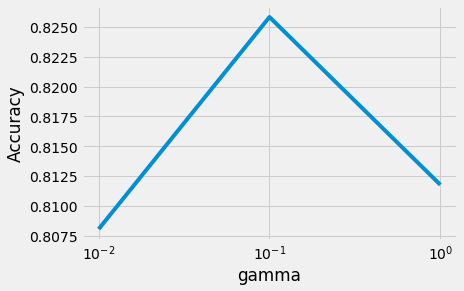

In [51]:
search_1d(SVC(), RobustScaler(), 'gamma', [10**i for i in range(-2, 1)], n_repeats=10, xscale='log')

In [52]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
params = {'C': [0.5, 0.8, 1, 3, 6], 
          'gamma': [0.01, 0.02]}
pipe = make_pipeline(
    RobustScaler(), GridSearchCV(SVC(), params, cv=kfold)
)
pipe.fit(X, y)

accs = np.array(pipe['gridsearchcv'].cv_results_['mean_test_score'])
best_params['svc_rbf'] = pipe['gridsearchcv'].best_params_
print(best_params['svc_rbf'])
print(pipe['gridsearchcv'].best_score_)

{'C': 6, 'gamma': 0.02}
0.8320896365576549


### Decision Tree

{'max_depth': 4}

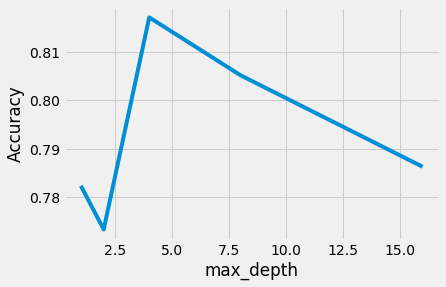

In [53]:
search_1d(DecisionTreeClassifier(), None, 'max_depth', [2**i for i in range(5)], n_repeats=10)

{'min_samples_leaf': 8}

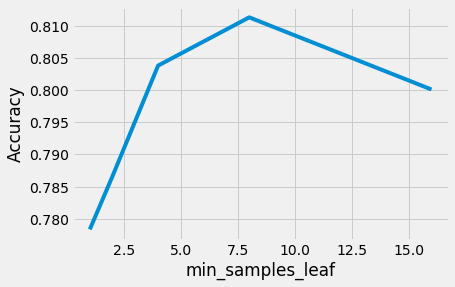

In [54]:
search_1d(DecisionTreeClassifier(), None, 'min_samples_leaf', [2**i for i in range(5)], n_repeats=10)

{'min_samples_split': 16}

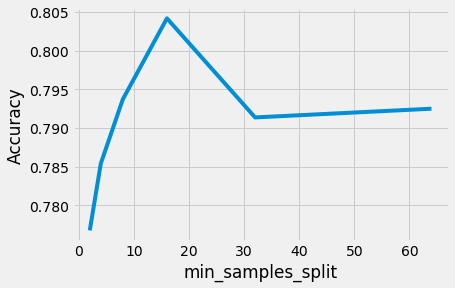

In [55]:
search_1d(DecisionTreeClassifier(), None, 'min_samples_split', [2**i for i in range(1, 7)], n_repeats=10)

In [56]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
params = {'max_depth': [8, 9, 10],
         'min_samples_leaf': [5, 6, 7],
         'min_samples_split': [10, 13, 16, 19, 22]}
grid = GridSearchCV(DecisionTreeClassifier(), params, cv=kfold)
grid.fit(X, y)
best_params['tree'] = grid.best_params_
print(best_params['tree'])
print(grid.best_score_)

{'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 10}
0.819868809239847


## RandomForestClassifier

{'n_estimators': 90}

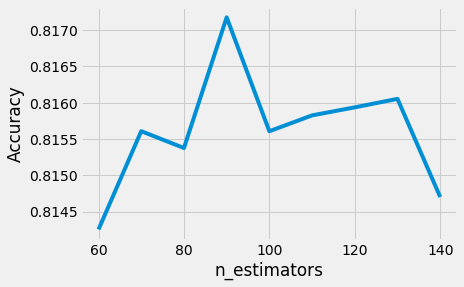

In [57]:
search_1d(RandomForestClassifier(), None, 'n_estimators', list(range(60,150,10)), n_repeats=10)

{'max_depth': 8}

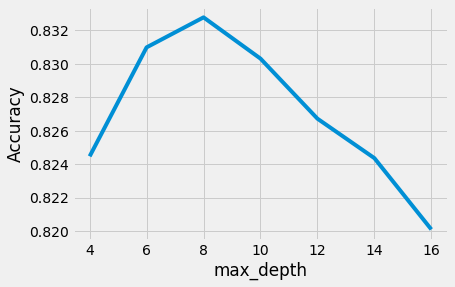

In [58]:
search_1d(RandomForestClassifier(n_estimators=60), None, 'max_depth', [4, 6, 8, 10, 12, 14, 16], n_repeats=10)

{'n_estimators': 70}

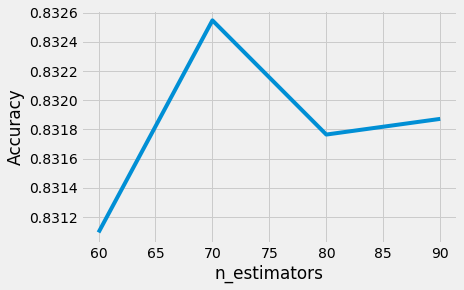

In [59]:
search_1d(RandomForestClassifier(max_depth=8), None, 'n_estimators', list(range(60,100,10)), n_repeats=10)

In [60]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
params = {'n_estimators': [70, 80],
          'max_depth': [8, 9]}
grid = GridSearchCV(RandomForestClassifier(), params, cv=kfold)
grid.fit(X, y)
best_params['forest'] = grid.best_params_
print(best_params['forest'])
print(grid.best_score_)

{'max_depth': 8, 'n_estimators': 80}
0.8334498775971377


### XGBClassifier

{'learning_rate': 0.2}

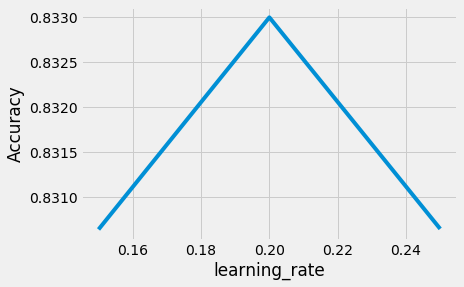

In [61]:
search_1d(XGBClassifier(), None, 'learning_rate', [0.15, 0.2, 0.25], n_repeats=10)

{'n_estimators': 100}

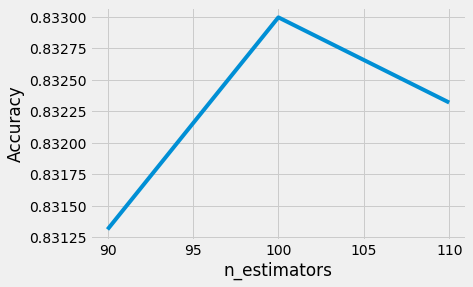

In [62]:
fixed_params = {'learning_rate': 0.2}
search_1d(XGBClassifier(**fixed_params), None, 'n_estimators', list(range(90, 120, 10)), n_repeats=10)

{'max_depth': 3}

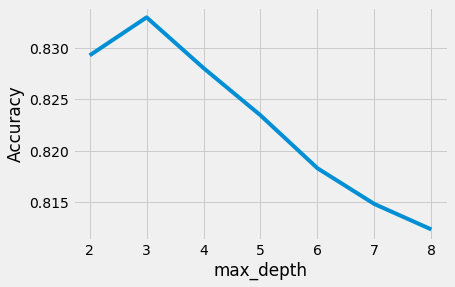

In [63]:
fixed_params['n_estimators'] = 100
search_1d(XGBClassifier(**fixed_params),
          None, 'max_depth', list(range(2, 9)), n_repeats=10)

{'min_child_weight': 8}

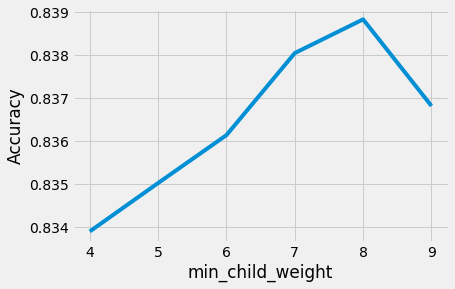

In [64]:
search_1d(XGBClassifier(**fixed_params),
         None, 'min_child_weight', list(range(4, 10)), n_repeats=10)

In [65]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
params = {'max_depth': [3, 4, 5, 6, 7],
         'min_child_weight': [7, 8, 9, 10]}
grid = GridSearchCV(XGBClassifier(**fixed_params), params, cv=kfold)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 4, 'min_child_weight': 7}
0.8411932709811061


{'gamma': 0.1}

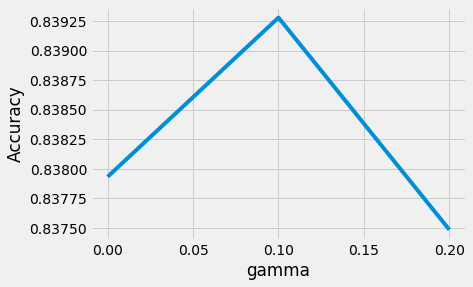

In [66]:
fixed_params['max_depth'] = 7
fixed_params['min_child_weight'] = 8
search_1d(XGBClassifier(**fixed_params),
         None, 'gamma', [0, 0.1, 0.2], n_repeats=10)

In [67]:
fixed_params['gamma'] = 0

{'subsample': 0.9}

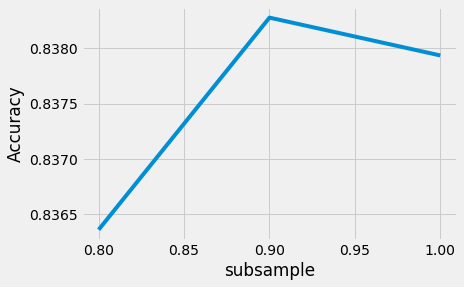

In [68]:
search_1d(XGBClassifier(**fixed_params),
         None, 'subsample', [0.1*i for i in range(8, 11)], n_repeats=10)

{'colsample_bytree': 0.7000000000000001}

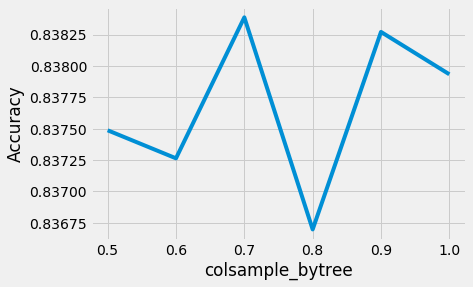

In [69]:
search_1d(XGBClassifier(**fixed_params),
         None, 'colsample_bytree', [0.1*i for i in range(5, 11)], n_repeats=10)

In [70]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
params = {'subsample': [0.9, 1],
         'colsample_bytree': [0.9, 1]}
grid = GridSearchCV(XGBClassifier(**fixed_params), params, cv=kfold)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'colsample_bytree': 1, 'subsample': 0.9}
0.8382738057874584


In [71]:
fixed_params['subsample'] = 1
fixed_params['colsample_bytree'] = 1

In [72]:
del fixed_params['learning_rate']

{'learning_rate': 0.2}

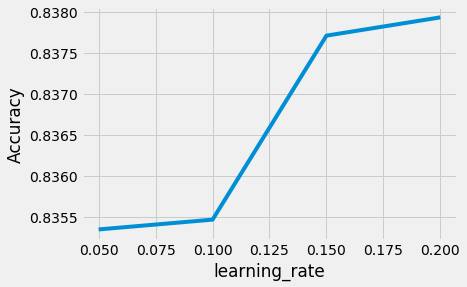

In [73]:
search_1d(XGBClassifier(**fixed_params),
         None, 'learning_rate', [0.05, 0.1, 0.15, 0.2], n_repeats=10)

In [74]:
fixed_params['learning_rate'] = 0.1
del fixed_params['n_estimators']

{'n_estimators': 120}

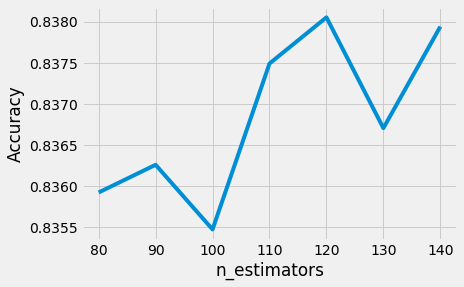

In [75]:
search_1d(XGBClassifier(**fixed_params),
         None, 'n_estimators', list(range(80, 150, 10)), n_repeats=10)

In [76]:
fixed_params['n_estimators'] = 100
best_params['xgb'] = fixed_params

# Comparison of Fine-Tuned Models

In [77]:
best_params

{'knn': {'n_neighbors': 12},
 'svc_linear': {'C': 5},
 'svc_rbf': {'C': 6, 'gamma': 0.02},
 'tree': {'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 10},
 'forest': {'max_depth': 8, 'n_estimators': 80},
 'xgb': {'max_depth': 7,
  'min_child_weight': 8,
  'gamma': 0,
  'subsample': 1,
  'colsample_bytree': 1,
  'learning_rate': 0.1,
  'n_estimators': 100}}

In [78]:
def score_model(model, n_repeats, metric_list, include_std=False):
    metrics_dict = {metric : [] for metric in metric_list}
    kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=0)
    results = cross_validate(model, X, y, scoring=metric_list, cv=kfold)
    for metric in metric_list:
        metrics_dict[metric].append(results['test_'+metric].mean())
    if include_std:
        return {metric : (np.mean(vec), np.std(vec)) for metric, vec in metrics_dict.items()}
    else:
        return {metric : np.mean(vec) for metric, vec in metrics_dict.items()}

In [79]:
classifiers = {
    'logistic_regression': make_pipeline(RobustScaler(), LogisticRegression()),
    'knn': make_pipeline(MinMaxScaler(), KNeighborsClassifier(**best_params['knn'])),
    'svc_linear': make_pipeline(RobustScaler(), SVC(kernel='linear', **best_params['svc_linear'])),
    'svc_rbf': make_pipeline(RobustScaler(), SVC(**best_params['svc_rbf'])),
    'tree': DecisionTreeClassifier(**best_params['tree']),
    'forest': RandomForestClassifier(**best_params['forest']),
    'xgb': XGBClassifier(**best_params['xgb'])
}

In [80]:
metric_list = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc']
val_accs_fine = pd.DataFrame(columns=metric_list)
for name, model in classifiers.items():
    val_accs_fine.loc[name] = score_model(model, 10, metric_list)
val_accs_fine

,accuracy,f1,recall,precision,roc_auc
logistic_regression,0.822556,0.762741,0.744740,0.783515,0.866844
knn,0.824018,0.749364,0.686910,0.826764,0.860917
svc_linear,0.832096,0.769639,0.731905,0.813451,0.857204
svc_rbf,0.831314,0.769272,0.733939,0.809944,0.853505
tree,0.819195,0.747811,0.701219,0.804187,0.840017
forest,0.832551,0.769110,0.728393,0.816855,0.875176
xgb,0.835469,0.773232,0.732178,0.820962,0.878785


We see that XGBClassifier outperforms the other models in all metrics except recall. Next we'll have a look at how much our fine-tuning actually improved our models. 

In [81]:
classifiers = {
    'logistic_regression': make_pipeline(RobustScaler(), LogisticRegression()),
    'knn': make_pipeline(MinMaxScaler(), KNeighborsClassifier()),
    'svc_linear': make_pipeline(RobustScaler(), SVC(kernel='linear')),
    'svc_rbf': make_pipeline(RobustScaler(), SVC()),
    'tree': DecisionTreeClassifier(),
    'forest': RandomForestClassifier(),
    'xgb': XGBClassifier()
}

In [82]:
metric_list = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc']
val_accs_def = pd.DataFrame(columns=metric_list)
for name, model in classifiers.items():
    val_accs_def.loc[name] = score_model(model, 10, metric_list)
val_accs_def

,accuracy,f1,recall,precision,roc_auc
logistic_regression,0.822556,0.762741,0.744740,0.783515,0.866844
knn,0.818309,0.751525,0.717890,0.791062,0.853283
svc_linear,0.830411,0.766950,0.728389,0.811854,0.856851
svc_rbf,0.825030,0.763999,0.739497,0.792286,0.861946
tree,0.776765,0.709251,0.711436,0.709703,0.765112
forest,0.814139,0.751562,0.734220,0.772576,0.866902
xgb,0.828395,0.763529,0.723730,0.810520,0.874077


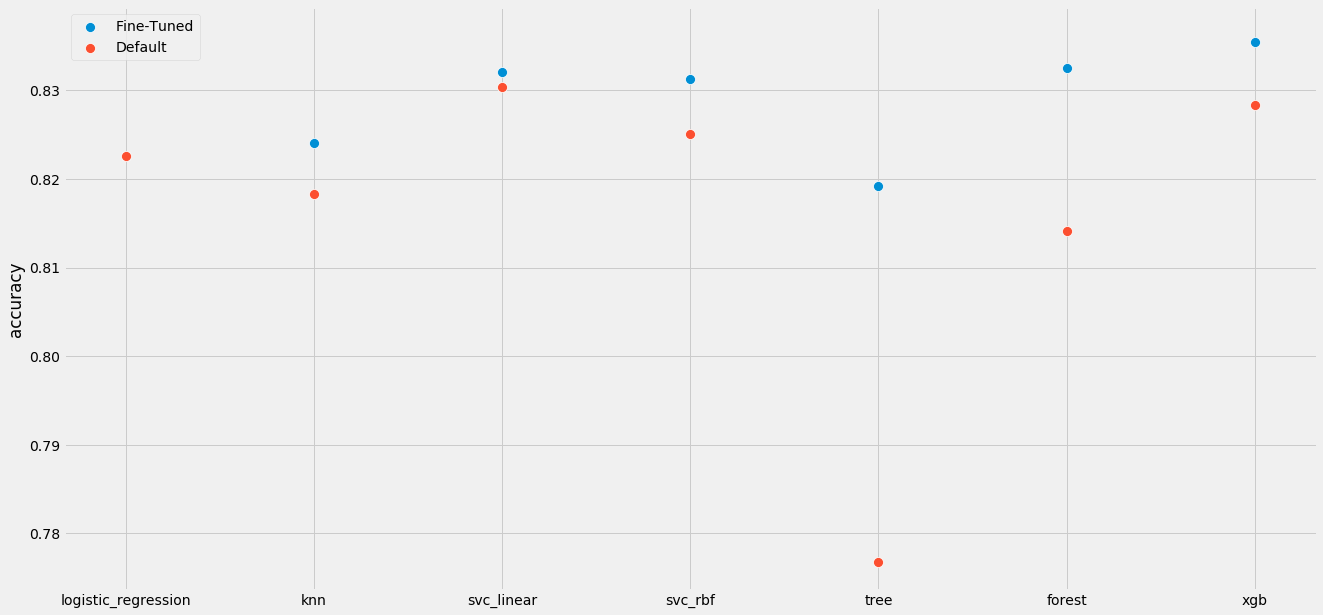

In [83]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=val_accs_fine.index, y=val_accs_fine['accuracy'], label='Fine-Tuned', ax=ax, s=100)
sns.scatterplot(x=val_accs_def.index, y=val_accs_def['accuracy'], label='Default', ax=ax, s=100)
plt.legend();

In [84]:
xgb = XGBClassifier(**best_params['xgb']).fit(X,y)
preds = xgb.predict(test).astype(int)

In [85]:
preds_df = pd.DataFrame({'PassengerId': test.index, 'Survived':preds})
preds_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [86]:
preds_df.to_csv('submission.csv', index=False)